In [3]:
import os

# 指定目录路径
dir_path = 'data/raw/sat3'

# 获取目录中的文件列表
file_list = os.listdir(dir_path)

# 打印文件列表
print(file_list)

['147_2025031706171299310.csv', '148_2025031706213197341.csv', '154_2025031706080334799.csv', '155_2025031706125033275.csv', '165_2025031706342776216.csv', '166_2025031706383157602.csv', '167_2025031706253370823.csv', '168_2025031706301084560.csv', '5_2025031706435044765.csv', '64_2025031707000877493.csv', '65_2025031707050544724.csv', '8_2025031706482963915.csv']


In [4]:
import pandas as pd
import os


# 加载目录中的CSV文件
csv_files = [f for f in file_list if f.endswith('.csv')]
dataframes = {}

for file in csv_files:
    file_path = os.path.join(dir_path, file)
    dataframes[file] = pd.read_csv(file_path)
    
# 打印已加载的CSV文件
print(f"已加载 {len(dataframes)} 个CSV文件")

已加载 12 个CSV文件


In [5]:
import pandas as pd
from datetime import datetime

# 处理每个CSV数据框，设置时间索引
for file, df in dataframes.items():
    # 添加列名（因为原始数据无表头）
    df.columns = ['timestamp', 'value']
    
    # 将时间戳列转换为datetime类型并设置为索引
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    
    # 更新dataframes字典
    dataframes[file] = df

# 打印第一个dataframe的前几行作为示例
if dataframes:
    first_file = list(dataframes.keys())[0]
    print(f"{first_file} 的前5行:")
    print(dataframes[first_file].head())

147_2025031706171299310.csv 的前5行:
                         value
timestamp                     
2024-01-01 00:07:36.286     20
2024-01-01 00:07:50.786     20
2024-01-01 00:08:05.786     20
2024-01-01 00:08:20.285     20
2024-01-01 00:08:35.285     20


                         timestamp
timestamp                         
2024-01-11 11:26:03.685     73.502
2024-02-06 06:28:25.743    324.495
2024-03-22 05:50:59.444    117.513
2024-03-22 05:53:12.442     58.514
2024-03-22 05:54:55.440     58.514
2024-03-22 05:59:35.936    206.012
2024-03-22 07:17:47.848   2433.962
2024-04-08 05:20:42.919     88.499
2024-04-08 07:09:38.327    132.007
2024-04-16 02:55:09.294     59.000
2024-07-04 10:30:02.444    158.692
2024-07-18 06:41:14.347     58.514
2024-07-21 18:12:00.311  65522.520
2024-07-24 01:20:11.313   4824.927
2024-07-24 01:24:36.809     73.499
2024-09-27 03:47:06.205     73.514
2024-11-11 18:12:02.979  36736.924
2024-12-10 03:48:07.054     59.000
2024-12-10 03:49:35.552     73.999
2024-12-16 06:05:19.307     73.999


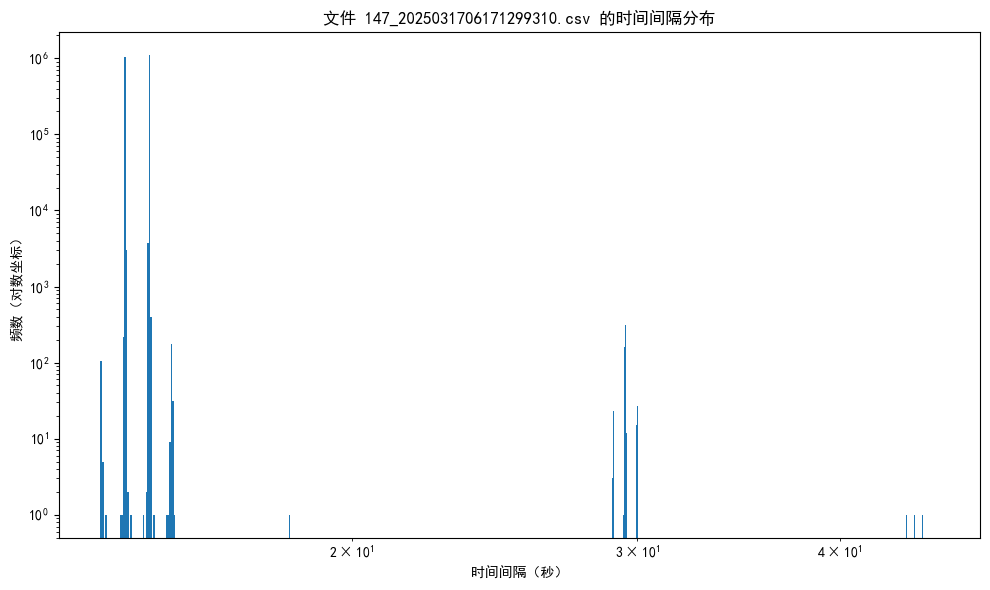

                         timestamp
timestamp                         
2024-01-11 11:26:03.685     73.502
2024-02-06 06:28:25.743    324.495
2024-03-22 05:50:59.444    117.513
2024-03-22 05:53:12.442     58.514
2024-03-22 05:54:55.440     58.514
2024-03-22 05:59:35.936    206.012
2024-03-22 07:17:47.848   2433.962
2024-04-08 05:20:42.919     88.499
2024-04-08 07:09:38.327    132.007
2024-04-16 02:55:09.294     59.000
2024-07-04 10:30:02.444    158.692
2024-07-18 06:41:14.347     58.514
2024-07-21 18:12:00.311  65522.520
2024-07-24 01:20:11.313   4824.927
2024-07-24 01:24:36.809     73.499
2024-09-27 03:47:06.205     73.514
2024-11-11 18:12:02.979  36736.924
2024-12-10 03:48:07.054     59.000
2024-12-10 03:49:35.552     73.999
2024-12-16 06:05:19.307     73.999


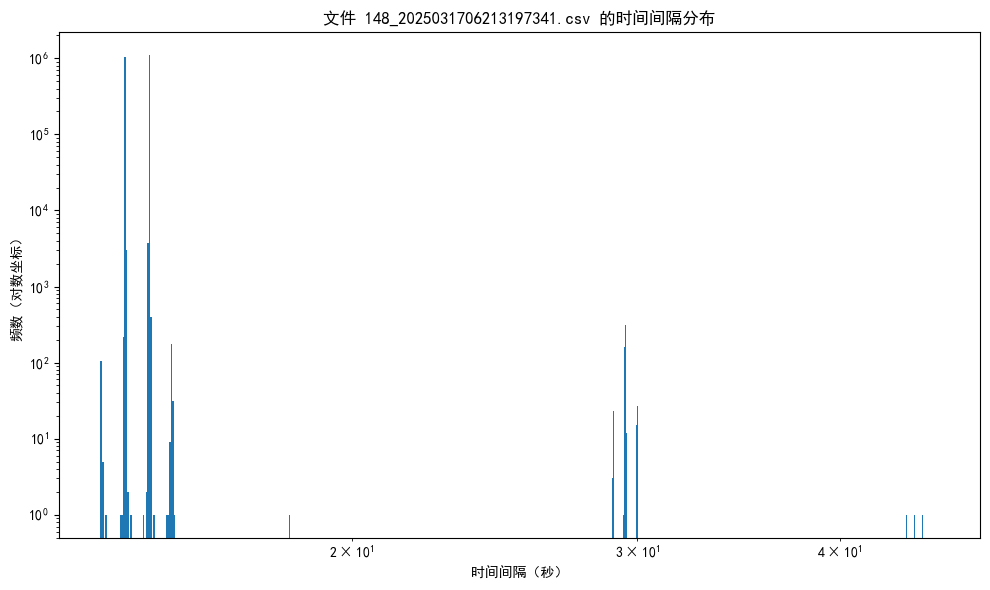

                         timestamp
timestamp                         
2024-01-11 11:26:03.685     73.502
2024-02-06 06:28:25.743    324.495
2024-03-22 05:50:59.444    117.513
2024-03-22 05:53:12.442     58.514
2024-03-22 05:54:55.440     58.514
2024-03-22 05:59:35.936    206.012
2024-03-22 07:17:47.848   2433.962
2024-04-08 05:20:42.919     88.499
2024-04-08 07:09:38.327    132.007
2024-04-16 02:55:09.294     59.000
2024-07-04 10:30:02.444    158.692
2024-07-18 06:41:14.347     58.514
2024-07-21 18:12:00.311  65522.520
2024-07-24 01:20:11.313   4824.927
2024-07-24 01:24:36.809     73.499
2024-09-27 03:47:06.205     73.514
2024-11-11 18:12:02.979  36736.924
2024-12-10 03:48:07.054     59.000
2024-12-10 03:49:35.552     73.999
2024-12-16 06:05:19.307     73.999


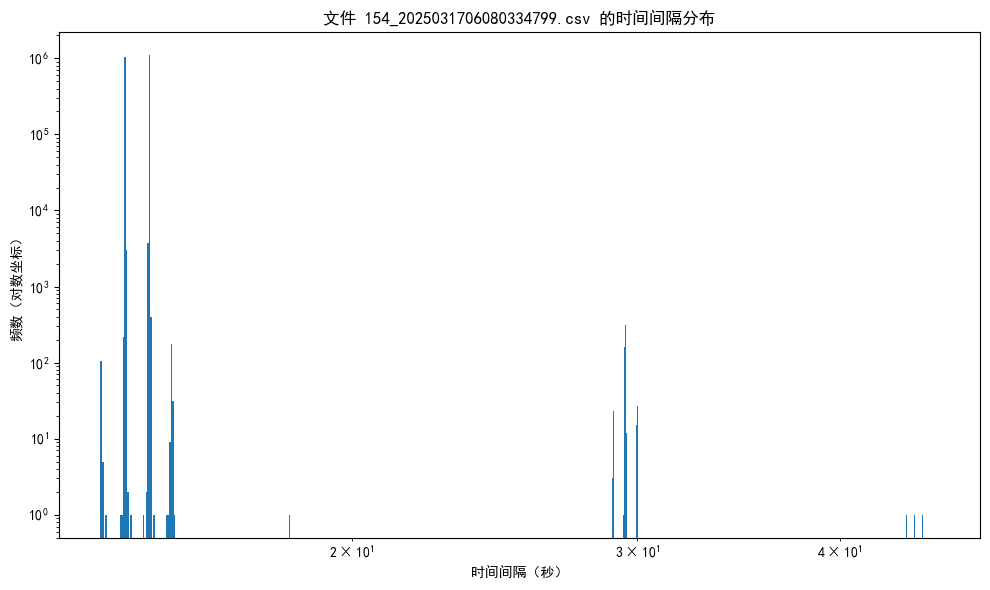

                         timestamp
timestamp                         
2024-01-11 11:26:03.685     73.502
2024-02-06 06:28:25.743    324.495
2024-03-22 05:50:59.444    117.513
2024-03-22 05:53:12.442     58.514
2024-03-22 05:54:55.440     58.514
2024-03-22 05:59:35.936    206.012
2024-03-22 07:17:47.848   2433.962
2024-04-08 05:20:42.919     88.499
2024-04-08 07:09:38.327    132.007
2024-04-16 02:55:09.294     59.000
2024-07-04 10:30:02.444    158.692
2024-07-18 06:41:14.347     58.514
2024-07-21 18:12:00.311  65522.520
2024-07-24 01:20:11.313   4824.927
2024-07-24 01:24:36.809     73.499
2024-09-27 03:47:06.205     73.514
2024-11-11 18:12:02.979  36736.924
2024-12-10 03:48:07.054     59.000
2024-12-10 03:49:35.552     73.999
2024-12-16 06:05:19.307     73.999


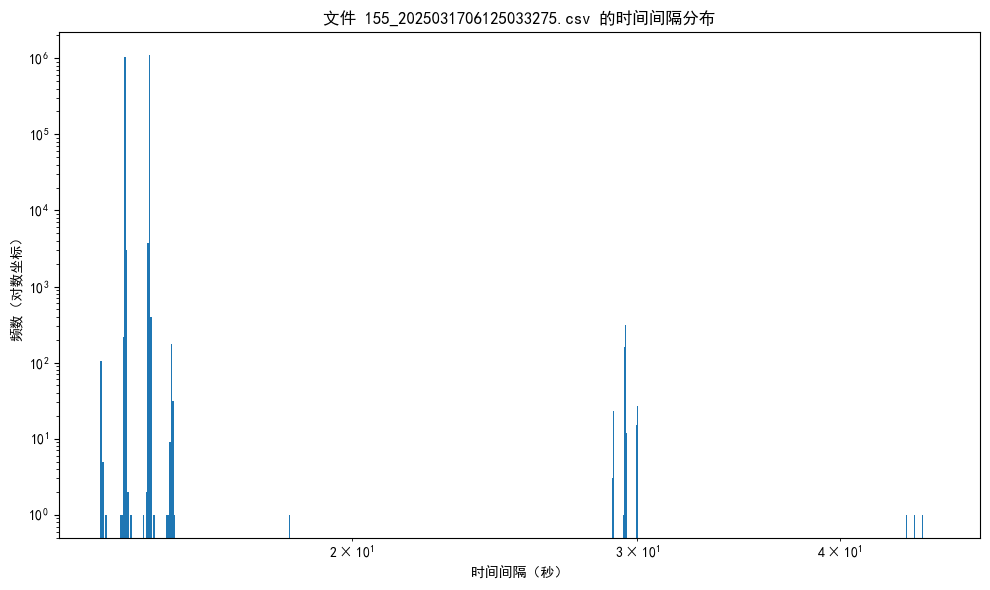

                         timestamp
timestamp                         
2024-01-11 11:26:03.685     73.502
2024-02-06 06:28:25.743    324.495
2024-03-22 05:50:59.444    117.513
2024-03-22 05:53:12.442     58.514
2024-03-22 05:54:55.440     58.514
2024-03-22 05:59:35.936    206.012
2024-03-22 07:17:47.848   2433.962
2024-04-08 05:20:42.919     88.499
2024-04-08 07:09:38.327    132.007
2024-04-16 02:55:09.294     59.000
2024-07-04 10:30:02.444    158.692
2024-07-18 06:41:14.347     58.514
2024-07-21 18:12:00.311  65522.520
2024-07-24 01:20:11.313   4824.927
2024-07-24 01:24:36.809     73.499
2024-09-27 03:47:06.205     73.514
2024-11-11 18:12:02.979  36736.924
2024-12-10 03:48:07.054     59.000
2024-12-10 03:49:35.552     73.999
2024-12-16 06:05:19.307     73.999


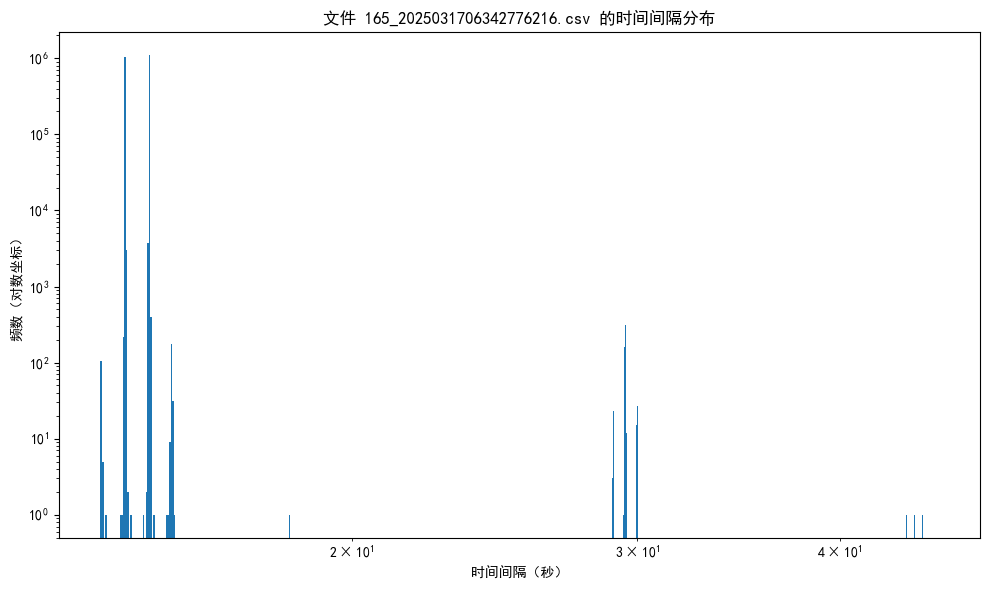

                         timestamp
timestamp                         
2024-01-11 11:26:03.685     73.502
2024-02-06 06:28:25.743    324.495
2024-03-22 05:50:59.444    117.513
2024-03-22 05:53:12.442     58.514
2024-03-22 05:54:55.440     58.514
2024-03-22 05:59:35.936    206.012
2024-03-22 07:17:47.848   2433.962
2024-04-08 05:20:42.919     88.499
2024-04-08 07:09:38.327    132.007
2024-04-16 02:55:09.294     59.000
2024-07-04 10:30:02.444    158.692
2024-07-18 06:41:14.347     58.514
2024-07-21 18:12:00.311  65522.520
2024-07-24 01:20:11.313   4824.927
2024-07-24 01:24:36.809     73.499
2024-09-27 03:47:06.205     73.514
2024-11-11 18:12:02.979  36736.924
2024-12-10 03:48:07.054     59.000
2024-12-10 03:49:35.552     73.999
2024-12-16 06:05:19.307     73.999


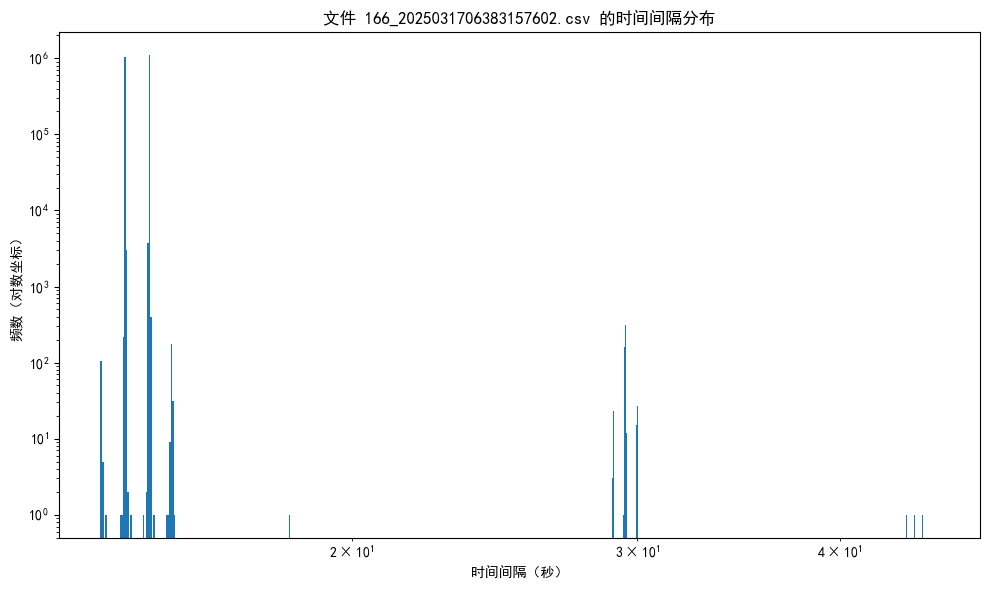

                         timestamp
timestamp                         
2024-01-11 11:26:03.685     73.502
2024-02-06 06:28:25.743    324.495
2024-03-22 05:50:59.444    117.513
2024-03-22 05:53:12.442     58.514
2024-03-22 05:54:55.440     58.514
2024-03-22 05:59:35.936    206.012
2024-03-22 07:17:47.848   2433.962
2024-04-08 05:20:42.919     88.499
2024-04-08 07:09:38.327    132.007
2024-04-16 02:55:09.294     59.000
2024-07-04 10:30:02.444    158.692
2024-07-18 06:41:14.347     58.514
2024-07-21 18:12:00.311  65522.520
2024-07-24 01:20:11.313   4824.927
2024-07-24 01:24:36.809     73.499
2024-09-27 03:47:06.205     73.514
2024-11-11 18:12:02.979  36736.924
2024-12-10 03:48:07.054     59.000
2024-12-10 03:49:35.552     73.999
2024-12-16 06:05:19.307     73.999


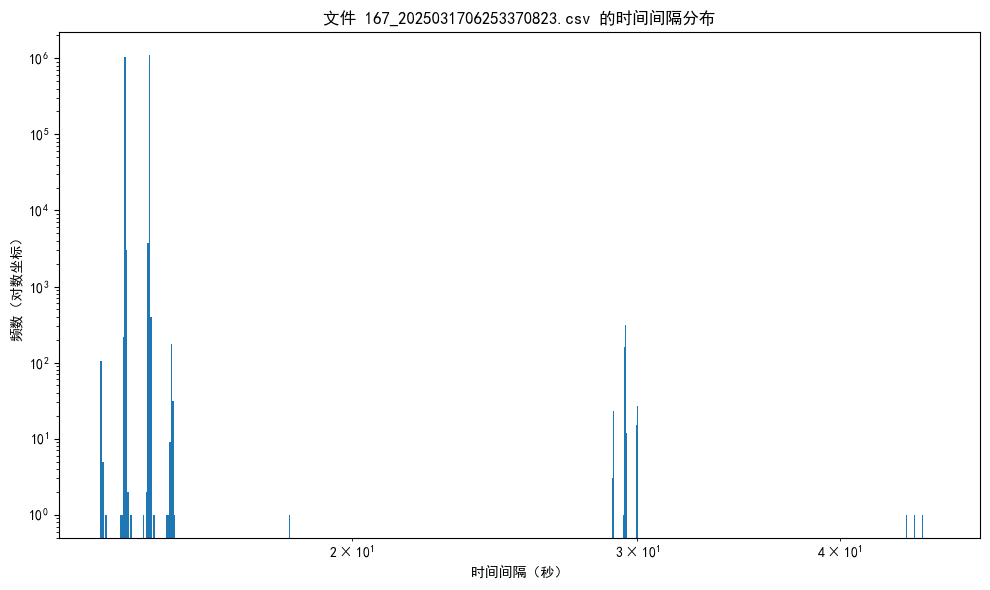

                         timestamp
timestamp                         
2024-01-11 11:26:03.685     73.502
2024-02-06 06:28:25.743    324.495
2024-03-22 05:50:59.444    117.513
2024-03-22 05:53:12.442     58.514
2024-03-22 05:54:55.440     58.514
2024-03-22 05:59:35.936    206.012
2024-03-22 07:17:47.848   2433.962
2024-04-08 05:20:42.919     88.499
2024-04-08 07:09:38.327    132.007
2024-04-16 02:55:09.294     59.000
2024-07-04 10:30:02.444    158.692
2024-07-18 06:41:14.347     58.514
2024-07-21 18:12:00.311  65522.520
2024-07-24 01:20:11.313   4824.927
2024-07-24 01:24:36.809     73.499
2024-09-27 03:47:06.205     73.514
2024-11-11 18:12:02.979  36736.924
2024-12-10 03:48:07.054     59.000
2024-12-10 03:49:35.552     73.999
2024-12-16 06:05:19.307     73.999


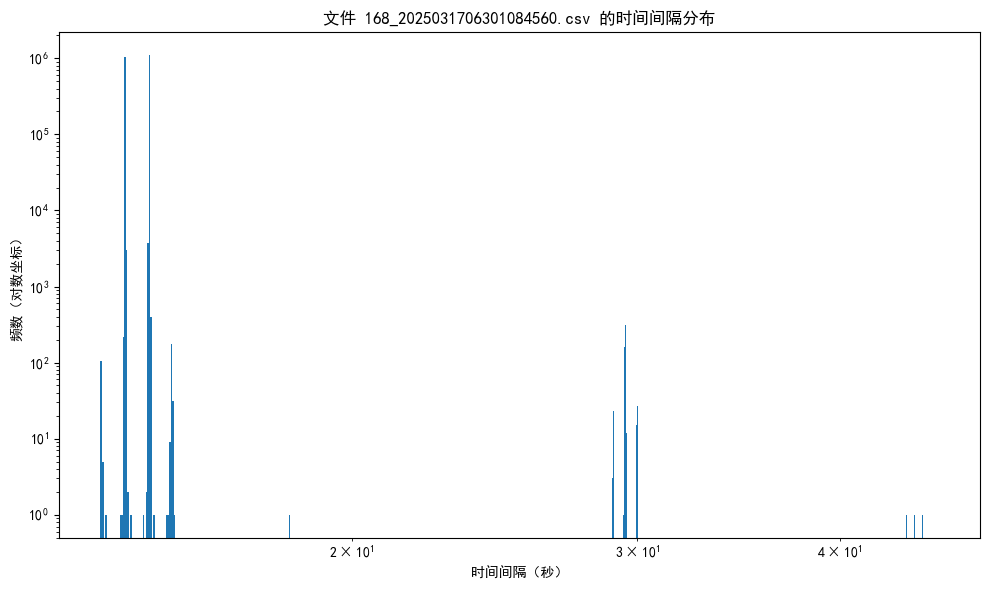

                         timestamp
timestamp                         
2024-01-11 11:22:09.189     59.003
2024-02-06 06:28:27.243    339.494
2024-03-22 05:51:00.944    117.513
2024-03-22 05:53:13.442     58.514
2024-03-22 05:54:56.940     58.514
2024-03-22 05:59:37.436    206.512
2024-03-22 07:17:34.348   2419.462
2024-04-08 05:20:44.419     88.999
2024-04-08 07:09:40.318    132.998
2024-07-04 10:30:03.944    158.692
2024-07-18 06:41:15.847     58.514
2024-07-21 18:12:01.811  65522.520
2024-07-24 01:20:12.313   4824.427
2024-07-24 01:24:38.309     73.999
2024-09-27 03:47:07.705     73.514
2024-11-11 18:12:03.979  36736.424
2024-12-10 03:48:08.054     59.000
2024-12-10 03:49:36.552     88.498
2024-12-16 06:05:20.807     73.999


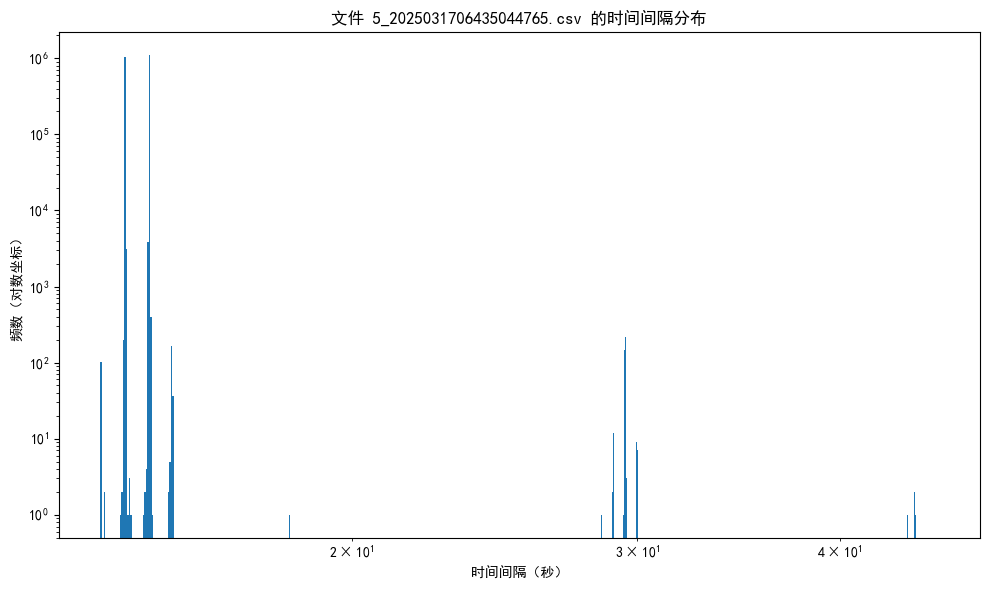

                         timestamp
timestamp                         
2024-01-11 11:30:13.187     59.533
2024-01-11 11:33:10.138     58.955
2024-02-06 06:28:24.243    324.995
2024-03-22 05:50:57.944    117.513
2024-03-22 05:53:10.442     58.514
2024-03-22 05:54:53.940     58.514
2024-03-22 05:59:34.436    206.512
2024-03-22 07:17:46.348   2433.962
2024-04-08 05:20:41.419     73.999
2024-04-08 05:25:20.924     58.509
2024-04-08 07:09:36.828    132.508
2024-07-04 10:30:15.944    159.192
2024-07-18 06:41:27.341     58.508
2024-07-21 18:11:58.811  65522.520
2024-07-24 01:20:09.813   4809.928
2024-07-24 01:24:35.309     73.999
2024-09-27 03:47:04.705     73.514
2024-11-11 18:12:15.979  36751.424
2024-12-10 03:48:05.054     59.000
2024-12-10 03:49:34.052     73.999
2024-12-16 06:05:17.807     73.999


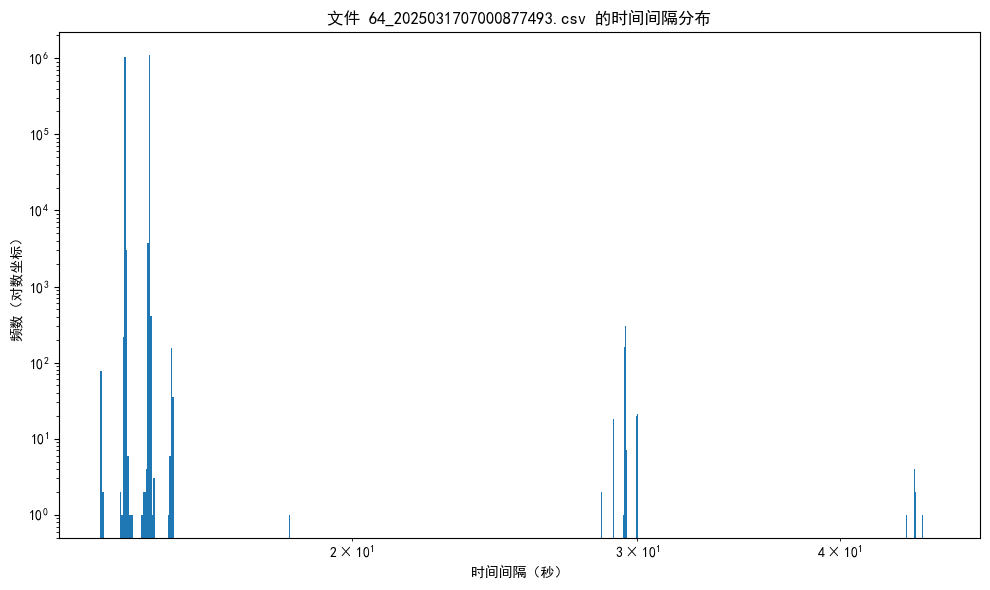

                         timestamp
timestamp                         
2024-01-11 11:30:13.187     59.533
2024-01-11 11:33:10.138     58.955
2024-02-06 06:28:24.243    324.995
2024-03-22 05:50:57.944    117.513
2024-03-22 05:53:10.442     58.514
2024-03-22 05:54:53.940     58.514
2024-03-22 05:59:34.436    206.512
2024-03-22 07:17:46.348   2433.962
2024-04-08 05:20:41.419     73.999
2024-04-08 05:25:20.924     58.509
2024-04-08 07:09:36.828    132.508
2024-07-04 10:30:15.944    159.192
2024-07-18 06:41:27.341     58.508
2024-07-21 18:11:58.811  65522.520
2024-07-24 01:20:09.813   4809.928
2024-07-24 01:24:35.309     73.999
2024-09-27 03:47:04.705     73.514
2024-11-11 18:12:15.979  36751.424
2024-12-10 03:48:05.054     59.000
2024-12-10 03:49:34.052     73.999
2024-12-16 06:05:17.807     73.999


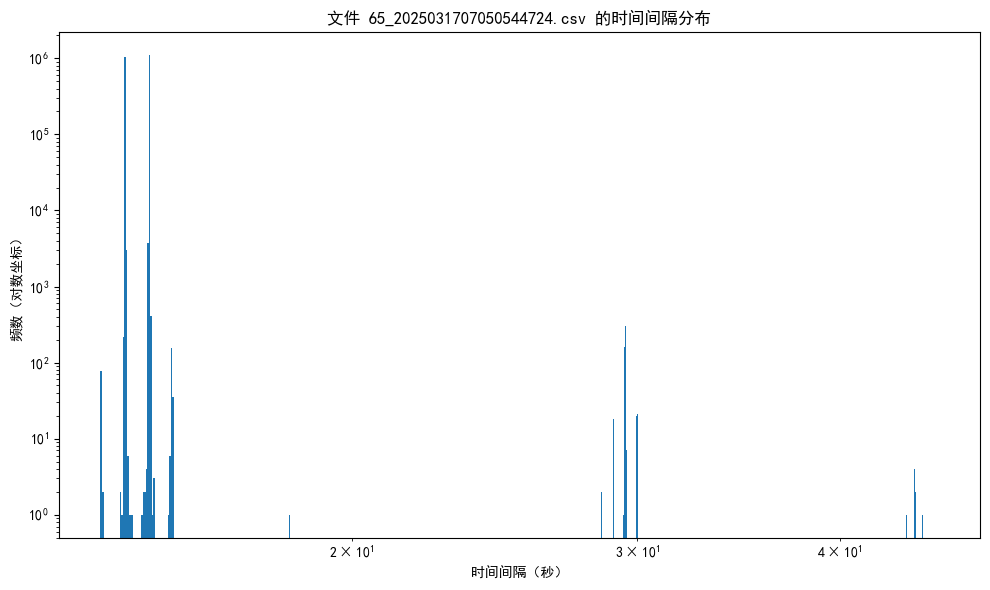

                         timestamp
timestamp                         
2024-01-11 11:22:09.189     59.003
2024-02-06 06:28:27.243    339.494
2024-03-22 05:51:00.944    117.513
2024-03-22 05:53:13.442     58.514
2024-03-22 05:54:56.940     58.514
2024-03-22 05:59:37.436    206.512
2024-03-22 07:17:34.348   2419.462
2024-04-08 05:20:44.419     88.999
2024-04-08 07:09:40.318    132.998
2024-07-04 10:30:03.944    158.692
2024-07-18 06:41:15.847     58.514
2024-07-21 18:12:01.811  65522.520
2024-07-24 01:20:12.313   4824.427
2024-07-24 01:24:38.309     73.999
2024-09-27 03:47:07.705     73.514
2024-11-11 18:12:03.979  36736.424
2024-12-10 03:48:08.054     59.000
2024-12-10 03:49:36.552     88.498
2024-12-16 06:05:20.807     73.999


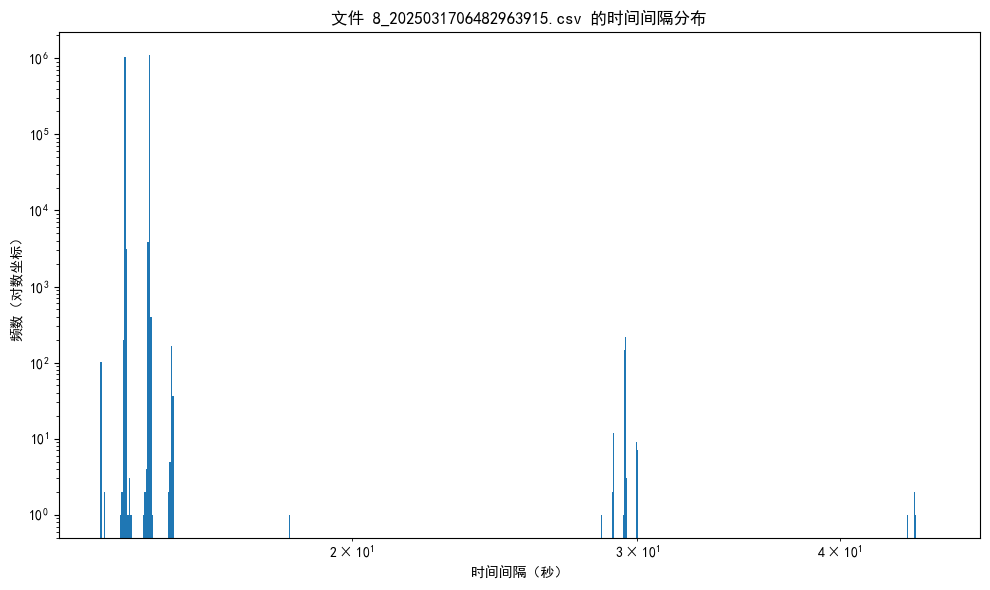

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体和负号显示
plt.rcParams['font.sans-serif'] = ['Simhei']  # 显示中文
plt.rcParams['axes.unicode_minus'] = False    # 显示负号

# 对每个dataframe绘制时间间隔分布图
for file, df in dataframes.items():
    # 计算时间间隔（毫秒）
    time_diffs = df.index.to_series().diff().dt.total_seconds().dropna().to_frame()
    # time_diffs.columns = ['time_diff']
    # print(time_diffs.head())
    print(time_diffs.loc[time_diffs['timestamp']>50])
    # print(time_diffs.max().values)
    # 创建新的图形
    plt.figure(figsize=(10, 6))
    
    # 绘制直方图，使用对数坐标
    plt.hist(time_diffs, bins=1000, range=(14, 46))
    plt.xscale('log')
    plt.yscale('log')
    
    # 设置标题和标签
    plt.title(f"文件 {file} 的时间间隔分布")
    plt.xlabel("时间间隔（秒）")
    plt.ylabel("频数（对数坐标）")
    
    # 显示图形
    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体和负号显示
plt.rcParams['font.sans-serif'] = ['Simhei']  # 显示中文
plt.rcParams['axes.unicode_minus'] = False    # 显示负号

# 对每个dataframe绘制时间间隔分布图
for file, df in dataframes.items():
    # 计算时间间隔（毫秒）
    time_diffs = df.index.to_series().diff().dt.total_seconds().dropna().to_frame()
    # time_diffs.columns = ['time_diff']
    # print(time_diffs.head())
    print(time_diffs.loc[time_diffs['timestamp']>50])
    # print(time_diffs.max().values)
    # 创建新的图形
    plt.figure(figsize=(10, 6))
    
    # 绘制直方图，使用对数坐标
    plt.hist(time_diffs, bins=1000, range=(14, 46))
    plt.xscale('log')
    plt.yscale('log')
    
    # 设置标题和标签
    plt.title(f"文件 {file} 的时间间隔分布")
    plt.xlabel("时间间隔（秒）")
    plt.ylabel("频数（对数坐标）")
    
    # 显示图形
    plt.tight_layout()
    plt.show()

import panel as pn
import hvplot.pandas
import pandas as pd

# 初始化 Panel
pn.extension()

# 创建文件选择器控件
file_selector = pn.widgets.MultiSelect(
    name='选择数据文件',
    options=list(dataframes.keys()),
    value=[list(dataframes.keys())[0]],
    height=200
)

# 创建交互式函数
@pn.depends(files=file_selector)
def plot_intervals(files):
    if not files:
        return pn.pane.Markdown("请选择至少一个文件")
    
    df = dataframes[files[0]]
    time_diffs = df.index.to_series().diff().dt.total_seconds().dropna()
    time_diffs.columns = ['time_diff']
    print(time_diffs)
    
    # 创建直方图
    plot = time_diffs.hvplot.hist(
        time_diffs,
        bins=100,
        xlim=(14.25, 15.25),
        # logy=True,
        title='时间间隔分布',
        xlabel='时间间隔（秒）',
        ylabel='频率（对数刻度）',
        height=500,
        width=800,
    )
    return plot

# 创建交互式面板
dashboard = pn.Column(
    pn.pane.Markdown("## 数据采集时间间隔分析"),
    pn.Row(
        file_selector,
        plot_intervals
    )
)

# 显示面板
dashboard

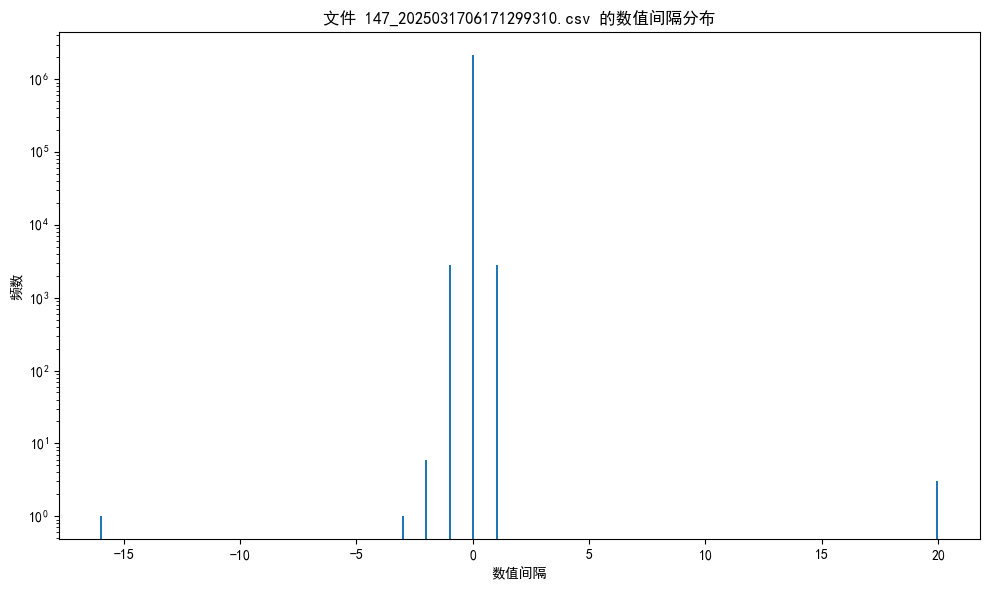

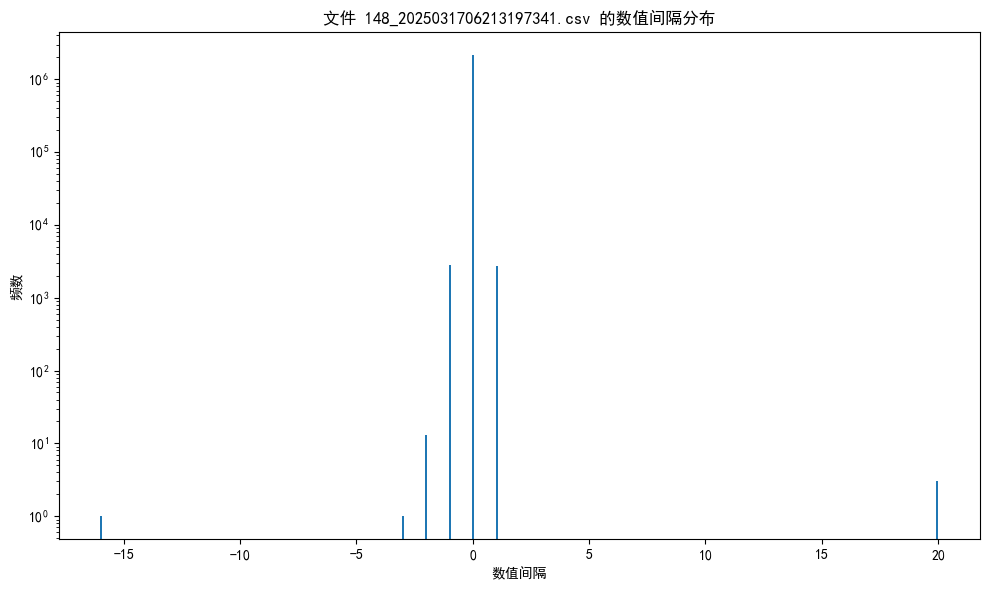

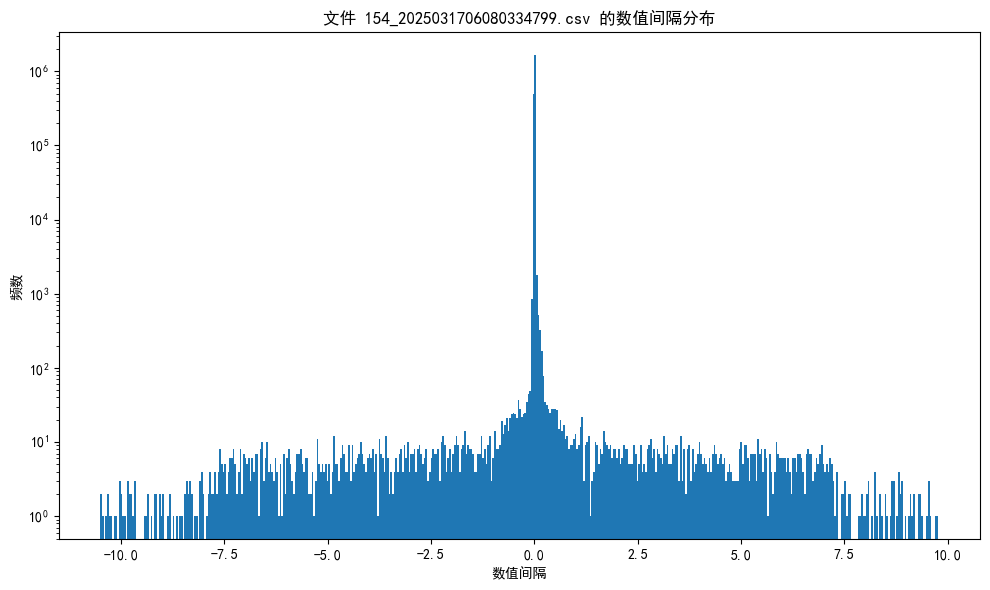

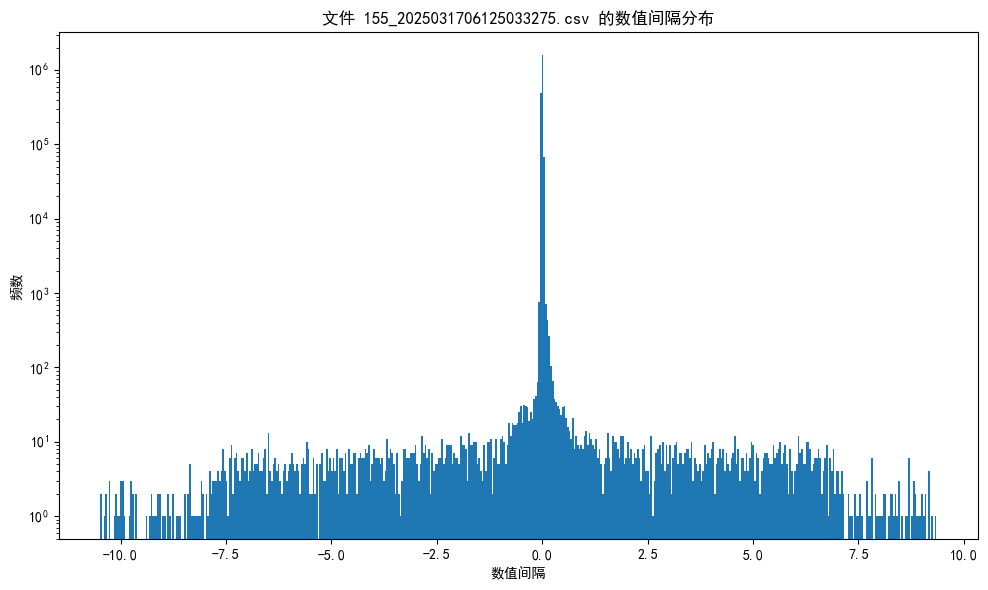

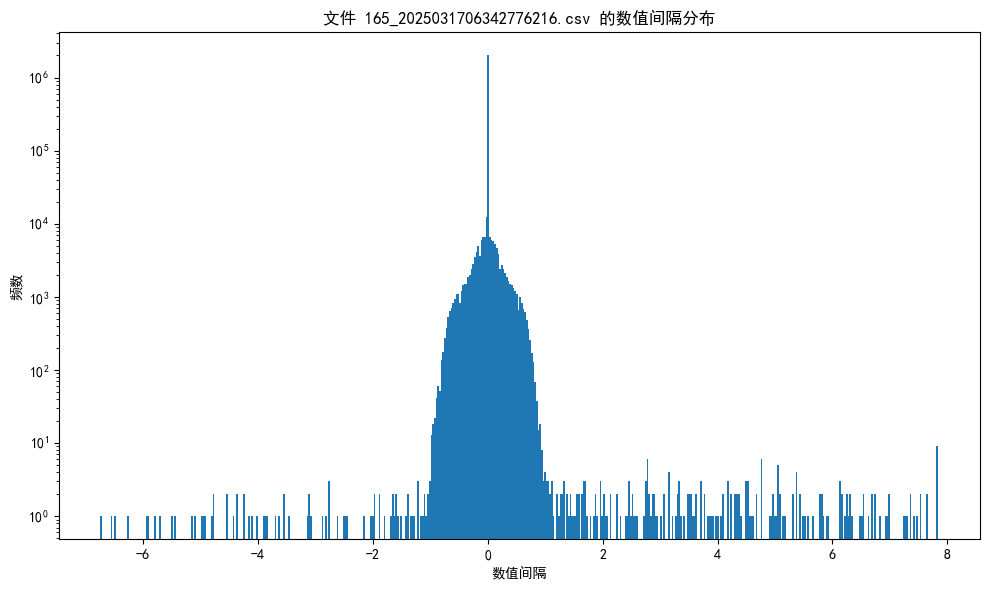

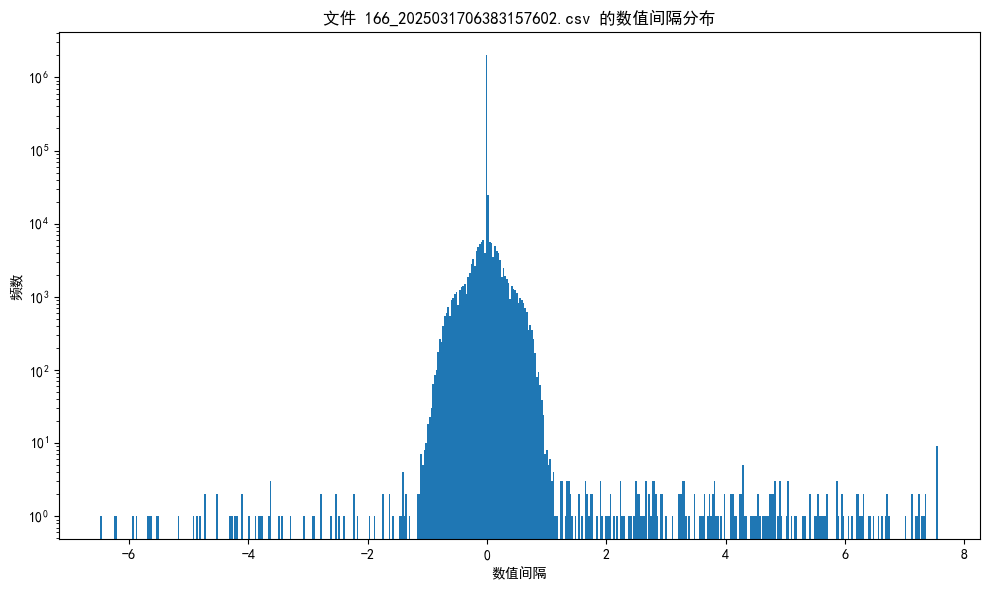

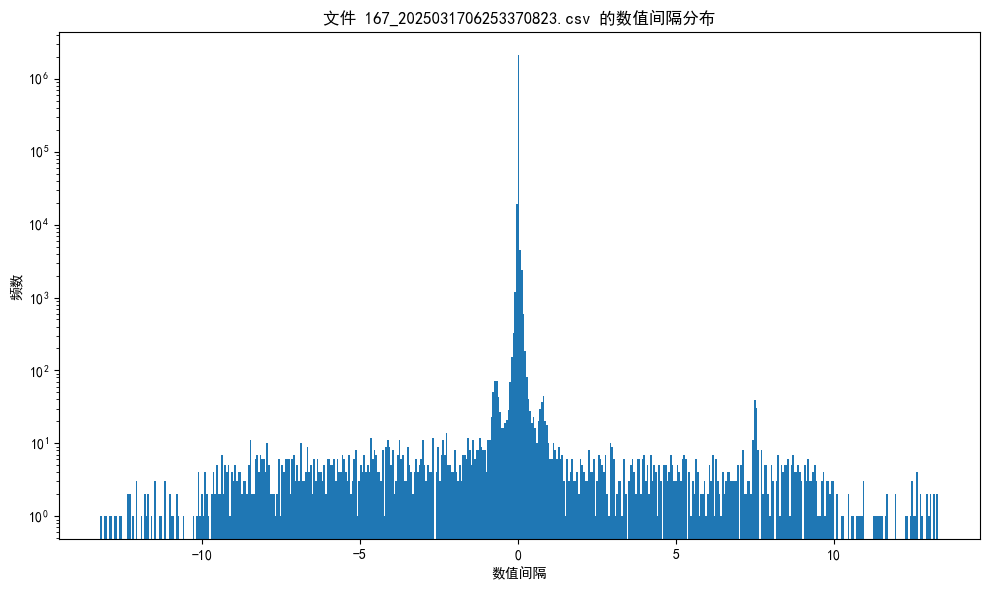

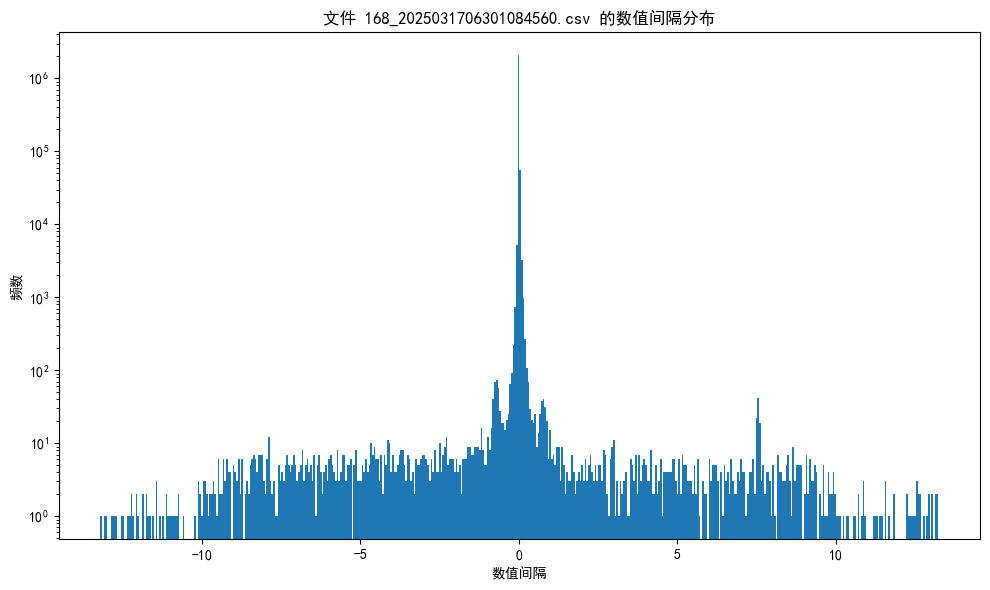

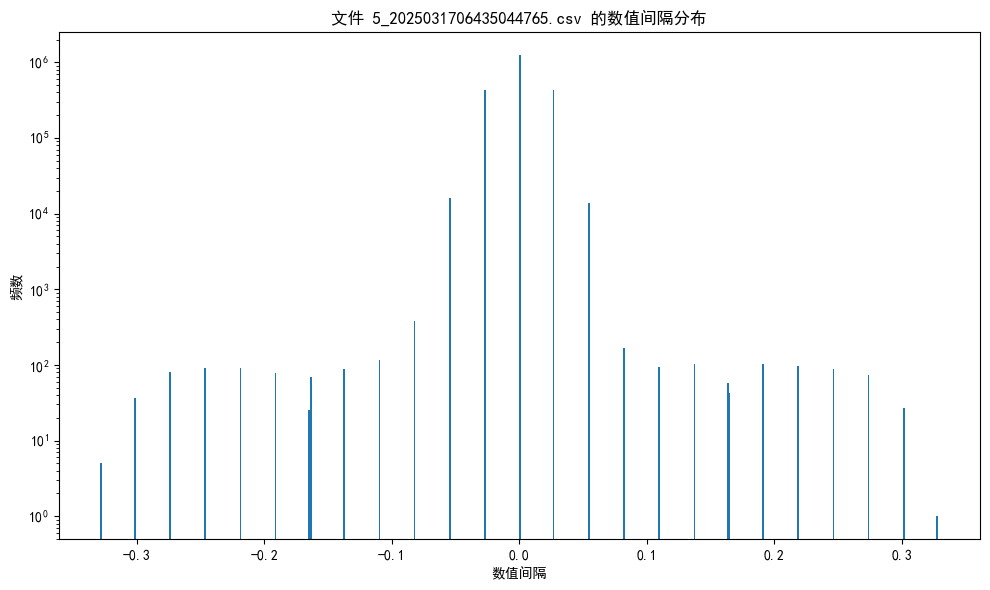

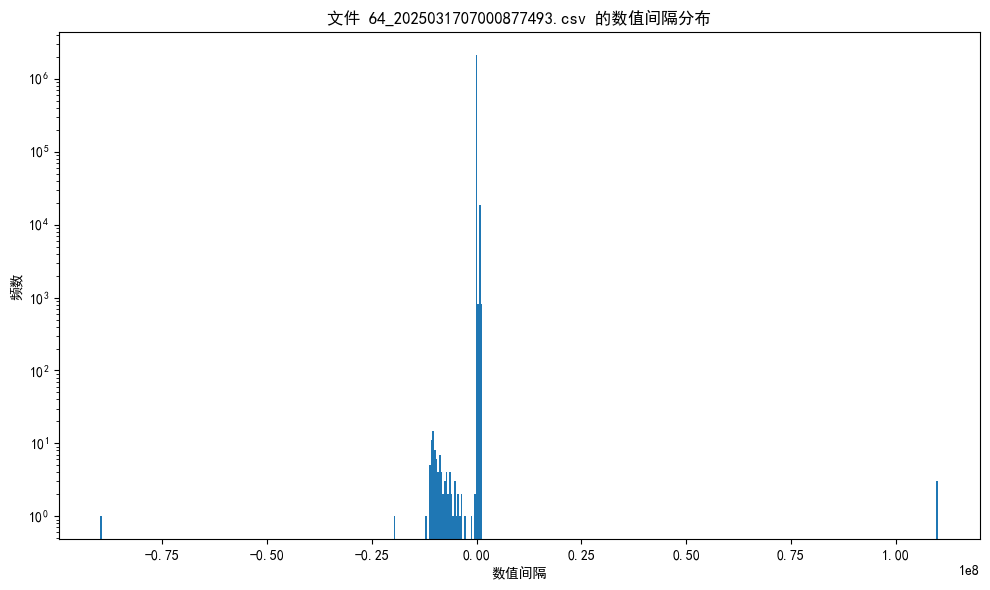

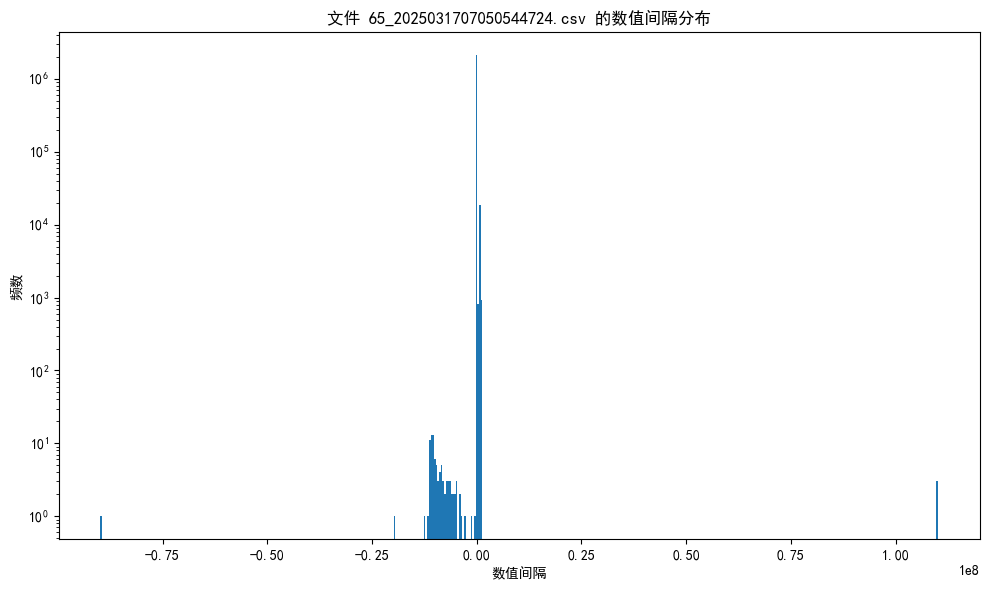

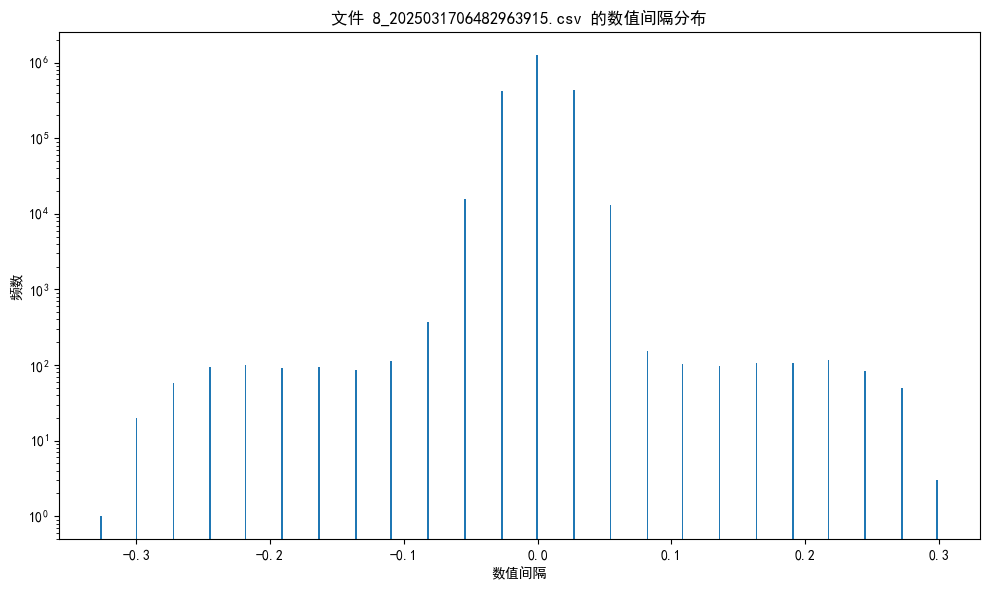

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体和负号显示
plt.rcParams['font.sans-serif'] = ['Simhei']  # 显示中文
plt.rcParams['axes.unicode_minus'] = False    # 显示负号

# 对每个dataframe绘制数值间隔分布图
for file, df in dataframes.items():
    # 计算数值间隔（相邻值之间的差）
    value_diffs = df['value'].diff().dropna()
    
    # 创建新的图形
    plt.figure(figsize=(10, 6))
    
    # 绘制直方图
    plt.hist(value_diffs, bins=500)
    
    plt.yscale('log')
    
    # 设置标题和标签
    plt.title(f"文件 {file} 的数值间隔分布")
    plt.xlabel("数值间隔")
    plt.ylabel("频数")
    
    # 显示图形
    plt.tight_layout()
    plt.show()

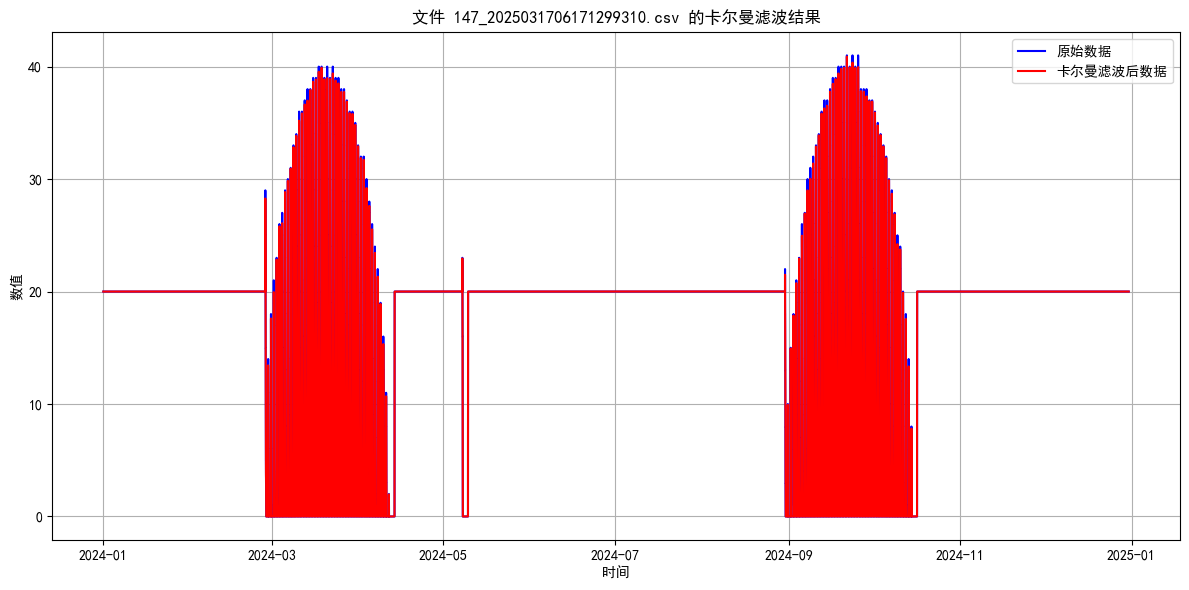

原始数据和滤波后数据的前5行：
                         value  kalman_filtered
timestamp                                      
2024-01-01 00:07:36.286     20             20.0
2024-01-01 00:07:50.786     20             20.0
2024-01-01 00:08:05.786     20             20.0
2024-01-01 00:08:20.285     20             20.0
2024-01-01 00:08:35.285     20             20.0


In [43]:
from pykalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt

# 获取第一个DataFrame的副本
first_file = list(dataframes.keys())[0]
df_copy = dataframes[first_file].copy()

# 提取value列数据作为观测值
observations = df_copy['value'].values

# 创建卡尔曼滤波器
kf = KalmanFilter(
    initial_state_mean=observations[0],
    transition_matrices=[1],
    observation_matrices=[1],
    transition_covariance=0.01,
    observation_covariance=1.0,
    initial_state_covariance=1.0
)

# 应用卡尔曼滤波
state_means, state_covs = kf.smooth(observations)

# 将滤波结果添加到DataFrame中
df_copy['kalman_filtered'] = state_means

# 绘制原始数据和滤波后的数据
plt.figure(figsize=(12, 6))
plt.plot(df_copy.index, df_copy['value'], 'b-', label='原始数据')
plt.plot(df_copy.index, df_copy['kalman_filtered'], 'r-', label='卡尔曼滤波后数据')
plt.title(f"文件 {first_file} 的卡尔曼滤波结果")
plt.xlabel("时间")
plt.ylabel("数值")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"原始数据和滤波后数据的前5行：")
print(df_copy.head())

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体和负号显示
plt.rcParams['font.sans-serif'] = ['Simhei']  # 显示中文
plt.rcParams['axes.unicode_minus'] = False    # 显示负号

# 计算数值间隔（相邻值之间的差）
value_diffs = df_copy['kalman_filtered'].diff().dropna()

# 创建新的图形
plt.figure(figsize=(10, 6))

# 绘制直方图
plt.hist(value_diffs, bins=500)

plt.yscale('log')

# 设置标题和标签
plt.title(f"文件 {file} 的数值间隔分布")
plt.xlabel("数值间隔")
plt.ylabel("频数")

# 显示图形
plt.tight_layout()
plt.show()

NameError: name 'df_copy' is not defined

                            value  sg_filtered
timestamp                                     
2024-01-01 00:07:37.286  79.35012    79.353741
2024-01-01 00:07:52.286  79.35012    79.344036
2024-01-01 00:08:06.786  79.32288    79.336543
2024-01-01 00:08:21.785  79.35012    79.331039
2024-01-01 00:08:36.285  79.32288    79.327303
...                           ...          ...
2024-01-01 00:30:59.255  79.32288    79.327265
2024-01-01 00:31:14.255  79.32288    79.326130
2024-01-01 00:31:28.755  79.32288    79.325511
2024-01-01 00:31:43.754  79.32288    79.326440
2024-01-01 00:31:58.254  79.35012    79.327884

[100 rows x 2 columns]


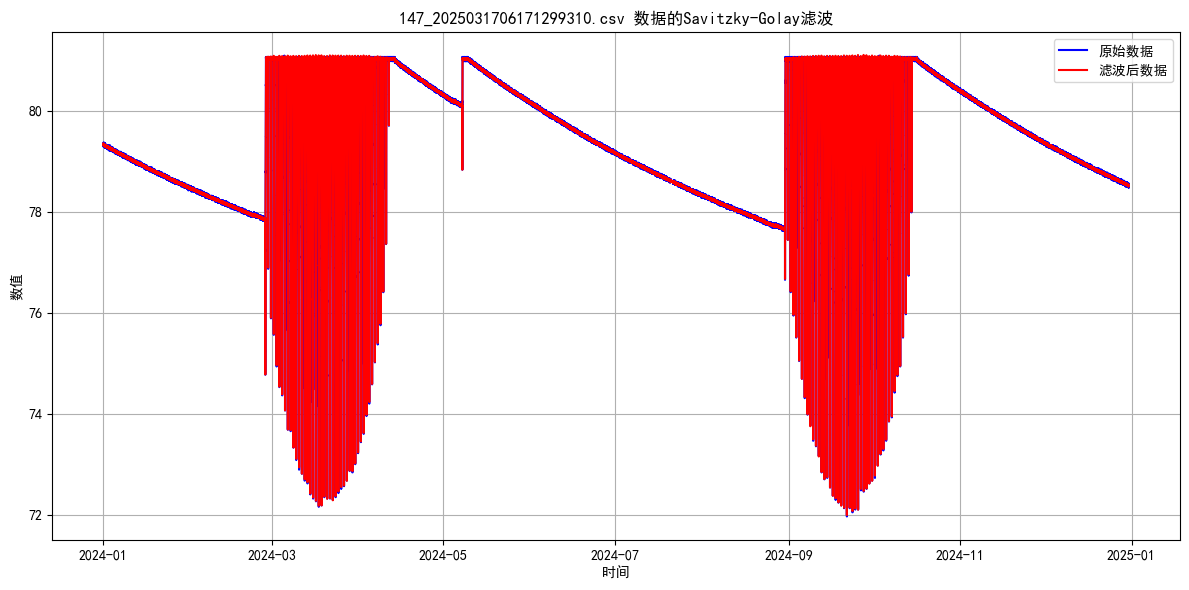

In [42]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

# 获取第一个数据框
file = list(dataframes.keys())[-1]
df_copy = dataframes[file].copy()
# print(df_copy.head())

# 应用Savitzky-Golay滤波
# 参数: 窗口长度=51, 多项式阶数=3
df_copy['sg_filtered'] = savgol_filter(df_copy['value'], window_length=20, polyorder=3)

print(df_copy.head(100))

# 绘制原始数据和滤波后的数据比较
plt.figure(figsize=(12, 6))
plt.plot(df_copy.index, df_copy['value'], 'b-', label='原始数据')
plt.plot(df_copy.index, df_copy['sg_filtered'], 'r-', label='滤波后数据')
plt.title(f"{first_file} 数据的Savitzky-Golay滤波")
plt.xlabel('时间')
plt.ylabel('数值')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

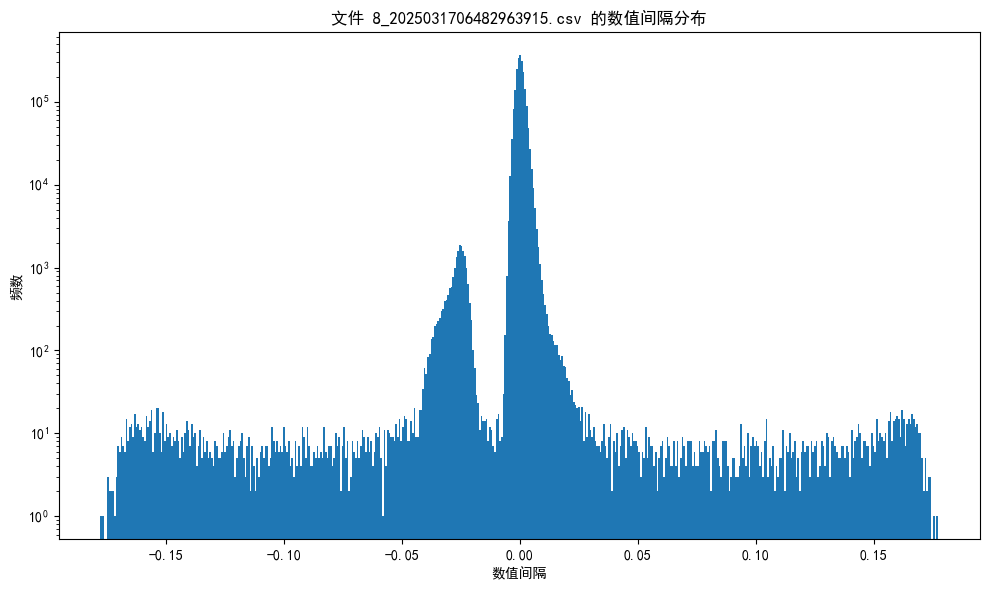

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体和负号显示
plt.rcParams['font.sans-serif'] = ['Simhei']  # 显示中文
plt.rcParams['axes.unicode_minus'] = False    # 显示负号

# 计算数值间隔（相邻值之间的差）
value_diffs = df_copy['sg_filtered'].diff().dropna()

# 创建新的图形
plt.figure(figsize=(10, 6))

# 绘制直方图
plt.hist(value_diffs, bins=500)

plt.yscale('log')

# 设置标题和标签
plt.title(f"文件 {file} 的数值间隔分布")
plt.xlabel("数值间隔")
plt.ylabel("频数")

# 显示图形
plt.tight_layout()
plt.show()

In [11]:
import panel as pn
import hvplot.pandas

# 初始化 Panel
pn.extension()

# 创建文件选择器控件
file_selector = pn.widgets.Select(
    name='选择数据文件',
    options=list(dataframes.keys()),
    value=list(dataframes.keys())[0]
)

# 创建交互式函数
@pn.depends(file=file_selector)
def plot_data(file):
    df = dataframes[file]
    plot = df.hvplot(
        y='value',
        responsive=True,
        downsample=True,
        xlabel='时间',
        ylabel='数值',
        height=500,
    )
    return plot

# 创建交互式面板
dashboard = pn.Column(
    pn.pane.Markdown("## 数据可视化"),
    pn.Column(
        file_selector,
        plot_data
    )
)

# 显示面板
dashboard

d:\Anaconda3\envs\py311cuda\Lib\site-packages\holoviews\operation\downsample.py:67: RuntimeWarning: overflow encountered in scalar multiply
  + (prev_x * avg_next_y - avg_next_x * prev_y)
d:\Anaconda3\envs\py311cuda\Lib\site-packages\holoviews\operation\downsample.py:67: RuntimeWarning: overflow encountered in scalar multiply
  + (prev_x * avg_next_y - avg_next_x * prev_y)


BokehModel(combine_events=True, render_bundle={'docs_json': {'f288b15a-ab24-4eee-ab5d-a16996964084': {'version…

d:\Anaconda3\envs\py311cuda\Lib\site-packages\holoviews\operation\downsample.py:67: RuntimeWarning: overflow encountered in scalar multiply
  + (prev_x * avg_next_y - avg_next_x * prev_y)
